## Agent Supervisor

The [previous example](multi-agent-collaboration.ipynb) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an LLM to orchestrate the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

![diagram](./img/supervisor-diagram.png)

To simplify the code in each agent node, we will use the AgentExecutor class from LangChain. This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

Before we build, let's configure our environment:

In [1]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langchain_experimental langsmith pandas langgraph

In [2]:
import getpass
import os

os.environ['OPENAI_API_KEY'] = ''
os.environ['TAVILY_API_KEY'] = ''

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ["LANGCHAIN_PROJECT"] = "Agent Supervisor"
os.environ['LANGCHAIN_API_KEY'] = ''

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [3]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

## Helper Utilities

Define a helper function below, which make it easier to add new agent worker nodes.

In [4]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

We can also define a function that we will use to be the nodes in the graph - it takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [5]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [7]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

Now connect all the edges in the graph.

In [8]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [11]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code drug discovery generative ai cancer researchers and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='Code drug discovery generative AI for cancer researchers', name='Coder')]}}
----
{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='I found some resources related to drug discovery generative AI for cancer researchers:\n\n1. [AI transforming drug discovery and assisting scientists](https://www.nature.com/articles/d43747-023-00029-9.pdf): Researchers at the University of Oxford have used generative AI to assist in drug discovery.\n\n2. [New AI tool for generating drug candidates for cancer](https://www.sciencedaily.com/releases/2024/05/240506131601.htm): Scientists at UC San Diego have developed a new AI tool to generate new drug candidates for cancer.\n\n3. [Hypothesis-driven AI in cancer research](https://cancerblog.mayoclinic.org/2024/04/30/mayo-researchers-invented-a-new-class-of-ai-to-improve-cancer-research-and-treatments/): Mayo Clinic researchers have 

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='The article at the link https://www.sciencedirect.com/science/article/pii/S135964462400117X discusses the transformation of the drug discovery process through the integration of artificial intelligence (AI). It highlights the role of AI in providing actionable insights from vast amounts of data and mentions the use of deep-learning models, particularly generative adversarial networks (GANs) and Autoencoders, to accelerate de novo drug design.\n\nThe article emphasizes the rapid progress in both artificial intelligence and computational power, noting the introduction of machine learning-based decision-making models and the subsequent incorporation of deep learning techniques as alternatives to virtual screening campaigns conducted in recent decades. It suggests that the data-enriched field of drug discovery favors machine learning and deep learning methods due to their effectiveness.\n\nThe in

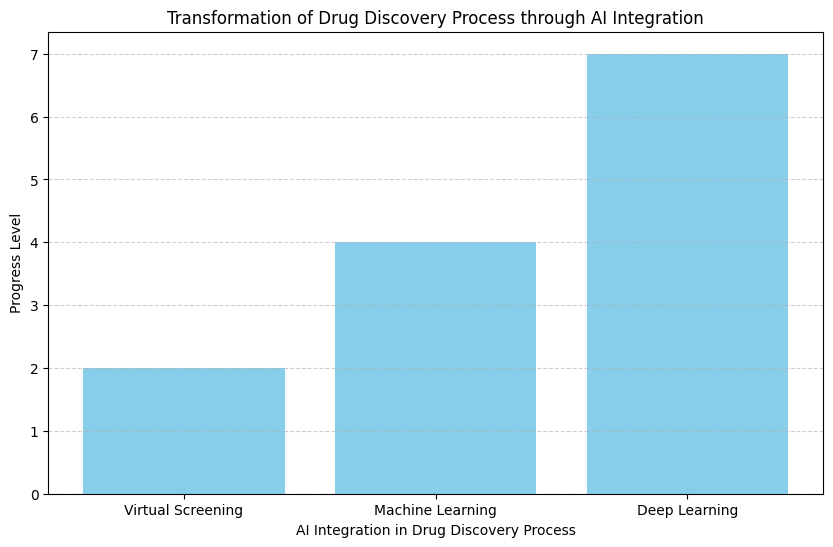

{'Coder': {'messages': [HumanMessage(content='Here is a bar chart representing the transformation of the drug discovery process through the integration of artificial intelligence. The chart illustrates the progress levels in different stages of AI integration, including Virtual Screening, Machine Learning, and Deep Learning. The chart shows how deep learning has made significant advancements in accelerating the drug discovery process compared to traditional methods like virtual screening.', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [14]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a research report on the article https://www.sciencedirect.com/science/article/pii/S135964462400117X.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")